# Project Mcnulty

** Prediction: Which team will win the match - Home team or Away team**

Load data, downloaded from Kaggle and clean up.

PART II  - Run Classification Models on goal features, draws included


In [1]:
from sqlalchemy import create_engine
import pandas as pd
import sqlite3
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
data = sqlite3.connect('/Users/keerthipamulaparthy/Documents/metis/projects/Project3_McNulty/database.sqlite')

In [2]:
df_raw = pd.read_sql_query(r"""SELECT A.id AS id, A.date AS date, country_id, league_id, season, stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,B.buildUpPlaySpeed AS H_bUPS,C.buildUpPlaySpeed AS A_bUPS,B.buildUpPlayDribblingClass AS H_bUPDC, C.buildUpPlayDribblingClass AS A_bUPDC,B.buildUpPlayPassing AS H_bUPP, C.buildUpPlayPassing AS A_bUPP,B.buildUpPlayPositioningClass AS H_bUPPosC, C.buildUpPlayPositioningClass AS A_bUPPosC,B.chanceCreationPassing AS H_cCP, C.chanceCreationPassing AS A_cCP,B.chanceCreationCrossing AS H_cCC, C.chanceCreationCrossing AS A_cCC,B.chanceCreationShooting AS H_cCS, C.chanceCreationShooting AS A_cCS,B.chanceCreationPositioningClass AS H_cCPosC, C.chanceCreationPositioningClass AS A_cCPosC,B.defencePressure AS H_dP, C.defencePressure AS A_dP,B.defenceAggression AS H_dA, C.defenceAggression AS A_dA,B.defenceTeamWidth AS H_dTW, C.defenceTeamWidth AS A_dTW,B.defenceDefenderLineClass AS H_dDLC, C.defenceDefenderLineClass AS A_dDLC FROM Match A JOIN Team_Attributes B ON A.home_team_api_id = B.team_api_id JOIN Team_Attributes C ON A.away_team_api_id = C.team_api_id WHERE substr(A.date,0,5)=substr(B.date,0,5) and substr(A.date,0,5)=substr(C.date,0,5) and season='2014/2015'""", data)


In [3]:
df_raw.head()

,id,date,country_id,league_id,season,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,H_cCPosC,A_cCPosC,H_dP,A_dP,H_dA,A_dA,H_dTW,A_dTW,H_dDLC,A_dDLC
0,1249,2014-07-25 00:00:00,1,1,2014/2015,1,1717817,9985,9986,3,...,Organised,Organised,45,42,54,48,52,49,Cover,Cover
1,1250,2014-07-26 00:00:00,1,1,2014/2015,1,1717818,8475,8342,0,...,Organised,Organised,25,51,37,50,35,57,Cover,Cover
2,1251,2014-07-26 00:00:00,1,1,2014/2015,1,1717819,9984,9991,0,...,Organised,Organised,59,55,47,59,62,52,Cover,Cover
3,1252,2014-07-26 00:00:00,1,1,2014/2015,1,1717820,9989,8573,2,...,Organised,Organised,38,42,49,47,65,44,Cover,Cover
4,1254,2014-07-27 00:00:00,1,1,2014/2015,1,1717822,8203,9987,3,...,Organised,Organised,42,47,51,45,52,55,Cover,Cover


In [5]:
df_raw.columns


Index([u'id', u'date', u'country_id', u'league_id', u'season', u'stage',
       u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'H_bUPS', u'A_bUPS', u'H_bUPDC',
       u'A_bUPDC', u'H_bUPP', u'A_bUPP', u'H_bUPPosC', u'A_bUPPosC', u'H_cCP',
       u'A_cCP', u'H_cCC', u'A_cCC', u'H_cCS', u'A_cCS', u'H_cCPosC',
       u'A_cCPosC', u'H_dP', u'A_dP', u'H_dA', u'A_dA', u'H_dTW', u'A_dTW',
       u'H_dDLC', u'A_dDLC'],
      dtype='object')

In [6]:
df_2014 = df_raw.reindex(columns = ['date', 
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'hometeam_outcome', 'HT_goalsfor',
    'HT_goalsagainst','AT_goalsfor','AT_goalsagainst'
    ,'H_bUPS','A_bUPS', 'H_bUPDC', 'A_bUPDC', 'H_bUPP', 'A_bUPP', 'H_bUPPosC',
       'A_bUPPosC', 'H_cCP', 'A_cCP', 'H_cCC', 'A_cCC', 'H_cCS',
       'A_cCS', 'H_cCPosC', 'A_cCPosC', 'H_dP', 'A_dP', 'H_dA', 'A_dA',
       'H_dTW', 'A_dTW', 'H_dDLC', 'A_dDLC'])


In [7]:
df_2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 35 columns):
date                3081 non-null object
match_api_id        3081 non-null int64
home_team_api_id    3081 non-null int64
away_team_api_id    3081 non-null int64
home_team_goal      3081 non-null int64
away_team_goal      3081 non-null int64
hometeam_outcome    0 non-null float64
HT_goalsfor         0 non-null float64
HT_goalsagainst     0 non-null float64
AT_goalsfor         0 non-null float64
AT_goalsagainst     0 non-null float64
H_bUPS              3081 non-null int64
A_bUPS              3081 non-null int64
H_bUPDC             3081 non-null object
A_bUPDC             3081 non-null object
H_bUPP              3081 non-null int64
A_bUPP              3081 non-null int64
H_bUPPosC           3081 non-null object
A_bUPPosC           3081 non-null object
H_cCP               3081 non-null int64
A_cCP               3081 non-null int64
H_cCC               3081 non-null int64
A_cCC        

In [8]:
df_2014['hometeam_outcome'] = df_2014['hometeam_outcome'].fillna('')
df_2014['HT_goalsfor'] = df_2014['HT_goalsfor'].fillna('')
df_2014['HT_goalsagainst'] = df_2014['HT_goalsagainst'].fillna('')
df_2014['AT_goalsfor'] = df_2014['AT_goalsfor'].fillna('')
df_2014['AT_goalsagainst'] = df_2014['AT_goalsagainst'].fillna('')

In [9]:
df_2014.loc[df_2014['home_team_goal'] > df_2014['away_team_goal'], 'hometeam_outcome'] = "w"
df_2014.loc[df_2014['home_team_goal'] < df_2014['away_team_goal'], 'hometeam_outcome'] = "l"
df_2014.loc[df_2014['home_team_goal'] == df_2014['away_team_goal'], 'hometeam_outcome'] = "d"

In [10]:
df_2014['hometeam_outcome'].value_counts()

w    1390
l     908
d     783
Name: hometeam_outcome, dtype: int64

In [11]:
df_2014.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,H_cCPosC,A_cCPosC,H_dP,A_dP,H_dA,A_dA,H_dTW,A_dTW,H_dDLC,A_dDLC
0,2014-07-25 00:00:00,1717817,9985,9986,3,0,w,,,,...,Organised,Organised,45,42,54,48,52,49,Cover,Cover
1,2014-07-26 00:00:00,1717818,8475,8342,0,2,l,,,,...,Organised,Organised,25,51,37,50,35,57,Cover,Cover
2,2014-07-26 00:00:00,1717819,9984,9991,0,0,d,,,,...,Organised,Organised,59,55,47,59,62,52,Cover,Cover
3,2014-07-26 00:00:00,1717820,9989,8573,2,0,w,,,,...,Organised,Organised,38,42,49,47,65,44,Cover,Cover
4,2014-07-27 00:00:00,1717822,8203,9987,3,1,w,,,,...,Organised,Organised,42,47,51,45,52,55,Cover,Cover


In [12]:
df_2014_new = df_2014.sort_values('date')
df_2014_new.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,H_cCPosC,A_cCPosC,H_dP,A_dP,H_dA,A_dA,H_dTW,A_dTW,H_dDLC,A_dDLC
1906,2014-07-18 00:00:00,1722098,8033,8023,2,3,l,,,,...,Organised,Organised,29,50,35,60,38,47,Cover,Cover
1903,2014-07-19 00:00:00,1722095,1957,8030,2,2,d,,,,...,Organised,Organised,57,37,56,58,49,63,Cover,Cover
2919,2014-07-19 00:00:00,1717214,9930,9931,1,2,l,,,,...,Organised,Organised,47,47,44,58,54,53,Cover,Cover
2920,2014-07-19 00:00:00,1717215,10190,10192,2,2,d,,,,...,Organised,Organised,40,44,41,34,52,50,Cover,Cover
1902,2014-07-20 00:00:00,1722092,2182,8028,4,0,w,,,,...,Organised,Organised,47,36,47,45,63,48,Cover,Cover


In [13]:
df_2014_new.columns

Index([u'date', u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'hometeam_outcome',
       u'HT_goalsfor', u'HT_goalsagainst', u'AT_goalsfor', u'AT_goalsagainst',
       u'H_bUPS', u'A_bUPS', u'H_bUPDC', u'A_bUPDC', u'H_bUPP', u'A_bUPP',
       u'H_bUPPosC', u'A_bUPPosC', u'H_cCP', u'A_cCP', u'H_cCC', u'A_cCC',
       u'H_cCS', u'A_cCS', u'H_cCPosC', u'A_cCPosC', u'H_dP', u'A_dP', u'H_dA',
       u'A_dA', u'H_dTW', u'A_dTW', u'H_dDLC', u'A_dDLC'],
      dtype='object')

In [14]:
len(df_2014_new)

3081

In [15]:
import datetime
df_2014_new['date'] = pd.to_datetime(df_2014_new['date'])

In [16]:
df_2014_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1906 to 1582
Data columns (total 35 columns):
date                3081 non-null datetime64[ns]
match_api_id        3081 non-null int64
home_team_api_id    3081 non-null int64
away_team_api_id    3081 non-null int64
home_team_goal      3081 non-null int64
away_team_goal      3081 non-null int64
hometeam_outcome    3081 non-null object
HT_goalsfor         3081 non-null object
HT_goalsagainst     3081 non-null object
AT_goalsfor         3081 non-null object
AT_goalsagainst     3081 non-null object
H_bUPS              3081 non-null int64
A_bUPS              3081 non-null int64
H_bUPDC             3081 non-null object
A_bUPDC             3081 non-null object
H_bUPP              3081 non-null int64
A_bUPP              3081 non-null int64
H_bUPPosC           3081 non-null object
A_bUPPosC           3081 non-null object
H_cCP               3081 non-null int64
A_cCP               3081 non-null int64
H_cCC               3081 non-nul

In [22]:
df_2014_new.columns

Index([u'date', u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'hometeam_outcome',
       u'HT_goalsfor', u'HT_goalsagainst', u'AT_goalsfor', u'AT_goalsagainst',
       u'H_bUPS', u'A_bUPS', u'H_bUPDC', u'A_bUPDC', u'H_bUPP', u'A_bUPP',
       u'H_bUPPosC', u'A_bUPPosC', u'H_cCP', u'A_cCP', u'H_cCC', u'A_cCC',
       u'H_cCS', u'A_cCS', u'H_cCPosC', u'A_cCPosC', u'H_dP', u'A_dP', u'H_dA',
       u'A_dA', u'H_dTW', u'A_dTW', u'H_dDLC', u'A_dDLC'],
      dtype='object')

In [23]:
len(df_2014_new)

3081

In [17]:
t1 = df_2014_new.merge(df_2014_new,on='home_team_api_id')
c1 = t1[t1['date_x']>=t1['date_y']].groupby(['match_api_id_x'])['home_team_goal_y','away_team_goal_y'].sum()
t1 = df_2014_new.merge(df_2014_new,left_on='home_team_api_id',right_on='away_team_api_id')
c2 = t1[t1['date_x']>=t1['date_y']].groupby(['match_api_id_x'])['home_team_goal_y','away_team_goal_y'].sum()
t1 = df_2014_new.merge(df_2014_new,on='away_team_api_id')
c3 = t1[t1['date_x']>=t1['date_y']].groupby(['match_api_id_x'])['home_team_goal_y','away_team_goal_y'].sum()
t1 = df_2014_new.merge(df_2014_new,left_on='away_team_api_id',right_on='home_team_api_id')
c4 = t1[t1['date_x']>=t1['date_y']].groupby(['match_api_id_x'])['home_team_goal_y','away_team_goal_y'].sum()

In [18]:
c1.reset_index(level=0,inplace=True)
c2.reset_index(level=0,inplace=True)
c3.reset_index(level=0,inplace=True)
c4.reset_index(level=0,inplace=True)

In [19]:
c = c1.merge(c2,on='match_api_id_x',how='outer').merge(c3,on='match_api_id_x',how='outer').merge(c4,on='match_api_id_x',how='outer')

In [20]:
c.columns = ['match_api_id_x','1','2','3','4','5','6','7','8']

In [21]:
c = c.fillna(0)

In [22]:
c['homegoalsfor'] = c['1']+c['4']
c['homegoalsagainst'] = c['2']+c['3']
c['awaygoalsfor'] = c['6']+c['7']
c['awaygoalsagainst'] = c['5']+c['8']

In [23]:
df_2014_2 = df_2014_new.merge(c,left_on='match_api_id',right_on='match_api_id_x')

In [24]:
df_2014_2.columns

Index([u'date', u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'hometeam_outcome',
       u'HT_goalsfor', u'HT_goalsagainst', u'AT_goalsfor', u'AT_goalsagainst',
       u'H_bUPS', u'A_bUPS', u'H_bUPDC', u'A_bUPDC', u'H_bUPP', u'A_bUPP',
       u'H_bUPPosC', u'A_bUPPosC', u'H_cCP', u'A_cCP', u'H_cCC', u'A_cCC',
       u'H_cCS', u'A_cCS', u'H_cCPosC', u'A_cCPosC', u'H_dP', u'A_dP', u'H_dA',
       u'A_dA', u'H_dTW', u'A_dTW', u'H_dDLC', u'A_dDLC', u'match_api_id_x',
       u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'homegoalsfor',
       u'homegoalsagainst', u'awaygoalsfor', u'awaygoalsagainst'],
      dtype='object')

In [25]:
df_2014_2.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,3,4,5,6,7,8,homegoalsfor,homegoalsagainst,awaygoalsfor,awaygoalsagainst
0,2014-07-18,1722098,8033,8023,2,3,l,,,,...,0.0,0.0,2,3,0.0,0.0,2.0,3.0,3.0,2.0
1,2014-07-19,1722095,1957,8030,2,2,d,,,,...,0.0,0.0,2,2,0.0,0.0,2.0,2.0,2.0,2.0
2,2014-07-19,1717214,9930,9931,1,2,l,,,,...,0.0,0.0,1,2,0.0,0.0,1.0,2.0,2.0,1.0
3,2014-07-19,1717215,10190,10192,2,2,d,,,,...,0.0,0.0,2,2,0.0,0.0,2.0,2.0,2.0,2.0
4,2014-07-20,1722092,2182,8028,4,0,w,,,,...,0.0,0.0,4,0,0.0,0.0,4.0,0.0,0.0,4.0


In [26]:
df_2014_2['HT_goalsfor'] = df_2014_2['homegoalsfor'] - df_2014_2['home_team_goal']
df_2014_2['AT_goalsagainst'] = df_2014_2['awaygoalsagainst'] - df_2014_2['home_team_goal']
df_2014_2['HT_goalsagainst'] = df_2014_2['homegoalsagainst'] - df_2014_2['away_team_goal']
df_2014_2['AT_goalsfor'] = df_2014_2['awaygoalsfor'] - df_2014_2['away_team_goal']

In [27]:
df_2014_2.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,3,4,5,6,7,8,homegoalsfor,homegoalsagainst,awaygoalsfor,awaygoalsagainst
0,2014-07-18,1722098,8033,8023,2,3,l,0.0,0.0,0.0,...,0.0,0.0,2,3,0.0,0.0,2.0,3.0,3.0,2.0
1,2014-07-19,1722095,1957,8030,2,2,d,0.0,0.0,0.0,...,0.0,0.0,2,2,0.0,0.0,2.0,2.0,2.0,2.0
2,2014-07-19,1717214,9930,9931,1,2,l,0.0,0.0,0.0,...,0.0,0.0,1,2,0.0,0.0,1.0,2.0,2.0,1.0
3,2014-07-19,1717215,10190,10192,2,2,d,0.0,0.0,0.0,...,0.0,0.0,2,2,0.0,0.0,2.0,2.0,2.0,2.0
4,2014-07-20,1722092,2182,8028,4,0,w,0.0,0.0,0.0,...,0.0,0.0,4,0,0.0,0.0,4.0,0.0,0.0,4.0


In [29]:
df_2014_2.loc[:,['HT_goalsfor','HT_goalsagainst','AT_goalsfor','AT_goalsagainst']].head()

,HT_goalsfor,HT_goalsagainst,AT_goalsfor,AT_goalsagainst
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0


**Calculate y-pred and compare with y-test**

In [30]:
df_2014_2['HT_precision'] = (df_2014_2['HT_goalsfor'] - df_2014_2['HT_goalsagainst'])/df_2014_2['HT_goalsfor']
df_2014_2['AT_precision'] = (df_2014_2['AT_goalsfor'] - df_2014_2['AT_goalsagainst'])/df_2014_2['AT_goalsfor'] 

In [31]:
df_2014_2['HT_precision'] = df_2014_2['HT_precision'].replace(np.inf, np.nan)
df_2014_2['AT_precision'] = df_2014_2['AT_precision'].replace(np.inf, np.nan)



In [32]:
df_2014_2['HT_precision'] = df_2014_2['HT_precision'].replace(-np.inf, np.nan)
df_2014_2['AT_precision'] = df_2014_2['AT_precision'].replace(-np.inf, np.nan)

In [33]:
df_2014_2['HT_precision'] = df_2014_2['HT_precision'].fillna('0')
df_2014_2['AT_precision'] = df_2014_2['AT_precision'].fillna('0')

In [34]:
df_2014_2.loc[:,['HT_precision','AT_precision']]

,HT_precision,AT_precision
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,-1,0


In [35]:
df_2014_2.loc[df_2014_2['HT_precision'] > df_2014_2['AT_precision'], 'prediction'] = "w"
df_2014_2.loc[df_2014_2['HT_precision'] < df_2014_2['AT_precision'], 'prediction'] = "l"
df_2014_2.loc[df_2014_2['HT_precision'] == df_2014_2['AT_precision'], 'prediction'] = "d"

In [36]:
df_2014_2['prediction'].value_counts()[0]+df_2014_2['prediction'].value_counts()[1]+df_2014_2['prediction'].value_counts()[2]

3081

In [37]:
df_2014_2['hometeam_outcome'].value_counts()[0]+df_2014_2['hometeam_outcome'].value_counts()[1]+df_2014_2['hometeam_outcome'].value_counts()[2]

3081

In [46]:
y_train_new = df_2014_2.loc[df_2014_2['date'].dt.year == 2014, 'prediction']
y_test_new = df_2014_2.loc[df_2014_2['date'].dt.year == 2015, 'prediction']


In [104]:
len(df_2014_2)

3081

In [105]:
hid = list(df_2014_2['home_team_api_id'])
aid = list(df_2014_2['away_team_api_id'])
outcome = list(df_2014_2['hometeam_outcome'])
hst = [0] * 3081
ast = [0] * 3081

In [107]:
for i in range(len(df_2014_2)):
    s = 0
    for j in range(i-1,-1,-1):
        if outcome[j] == 'd':
            continue
        if hid[i] == hid[j]:
            if outcome[j] == 'w':
                r = 1
            if outcome[j] == 'l':
                r = -1
        elif hid[i] == aid[j]:
            if outcome[j] == 'w':
                r = -1
            if outcome[j] == 'l':
                r = 1
        else:
            continue
        if s*r>=0:
            s+=r
        else:
            hst[i] = s
            break

In [109]:
for i in range(len(df_2014_2)):
    s = 0
    for j in range(i-1,-1,-1):
        if outcome[j] == 'd':
            continue
        if aid[i] == hid[j]:
            if outcome[j] == 'w':
                r = 1
            if outcome[j] == 'l':
                r = -1
        elif aid[i] == aid[j]:
            if outcome[j] == 'w':
                r = -1
            if outcome[j] == 'l':
                r = 1
        else:
            continue
        if s*r>=0:
            s+=r
        else:
            ast[i] = s
            break

In [111]:
df_2014_2['HT_streak'] = hst
df_2014_2['AT_streak'] = ast

In [112]:
temp2 = df_2014_2[['home_team_api_id','away_team_api_id','HT_goalsfor','HT_goalsagainst','AT_goalsfor','AT_goalsagainst','HT_streak','AT_streak','prediction','hometeam_outcome']]

In [113]:
temp2[(temp2['prediction']!=temp2['hometeam_outcome']) & (temp2['prediction']!='d') & (temp2['hometeam_outcome']!='d')]

,home_team_api_id,away_team_api_id,HT_goalsfor,HT_goalsagainst,AT_goalsfor,AT_goalsagainst,HT_streak,AT_streak,prediction,hometeam_outcome
9,9930,10179,1.0,2.0,1.0,1.0,0,0,l,w
10,10243,10191,1.0,0.0,0.0,0.0,0,0,l,w
14,8023,8025,3.0,2.0,2.0,0.0,0,0,l,w
18,9956,10191,0.0,1.0,1.0,2.0,0,0,w,l
19,10179,10190,1.0,2.0,2.0,2.0,0,0,l,w
20,8027,1957,2.0,0.0,2.0,2.0,0,0,w,l
31,8571,9985,0.0,2.0,3.0,0.0,0,0,w,l
34,8025,8027,3.0,4.0,3.0,3.0,-1,-1,l,w
36,2182,10265,4.0,0.0,1.0,1.0,0,0,w,l
41,8033,1601,2.0,4.0,0.0,2.0,0,0,l,w


In [115]:
df_2014_2[1:50]

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,hometeam_outcome,HT_goalsfor,HT_goalsagainst,AT_goalsfor,...,8,homegoalsfor,homegoalsagainst,awaygoalsfor,awaygoalsagainst,HT_precision,AT_precision,prediction,HT_streak,AT_streak
1,2014-07-19,1722095,1957,8030,2,2,d,0.0,0.0,0.0,...,0.0,2.0,2.0,2.0,2.0,0,0,d,0,0
2,2014-07-19,1717214,9930,9931,1,2,l,0.0,0.0,0.0,...,0.0,1.0,2.0,2.0,1.0,0,0,d,0,0
3,2014-07-19,1717215,10190,10192,2,2,d,0.0,0.0,0.0,...,0.0,2.0,2.0,2.0,2.0,0,0,d,0,0
4,2014-07-20,1722092,2182,8028,4,0,w,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,4.0,0,0,d,0,0
5,2014-07-20,1722096,8027,8245,2,0,w,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,0,0,d,0,0
6,2014-07-20,1722097,8025,1601,2,0,w,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,0,0,d,0,0
7,2014-07-20,1717217,10199,10179,1,1,d,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0,0,d,0,0
8,2014-07-20,1717218,10243,9956,1,0,w,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0,0,d,0,0
9,2014-07-23,1717219,9930,10179,1,0,w,1.0,2.0,1.0,...,0.0,2.0,2.0,1.0,2.0,-1,0,l,0,0
10,2014-07-23,1717220,10243,10191,2,1,w,1.0,0.0,0.0,...,0.0,3.0,1.0,1.0,2.0,1,0,l,0,0


**Model fitting for only 4 goal features**

In [51]:
df_2014_2.columns

Index([u'date', u'match_api_id', u'home_team_api_id', u'away_team_api_id',
       u'home_team_goal', u'away_team_goal', u'hometeam_outcome',
       u'HT_goalsfor', u'HT_goalsagainst', u'AT_goalsfor', u'AT_goalsagainst',
       u'H_bUPS', u'A_bUPS', u'H_bUPDC', u'A_bUPDC', u'H_bUPP', u'A_bUPP',
       u'H_bUPPosC', u'A_bUPPosC', u'H_cCP', u'A_cCP', u'H_cCC', u'A_cCC',
       u'H_cCS', u'A_cCS', u'H_cCPosC', u'A_cCPosC', u'H_dP', u'A_dP', u'H_dA',
       u'A_dA', u'H_dTW', u'A_dTW', u'H_dDLC', u'A_dDLC', u'match_api_id_x',
       u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'homegoalsfor',
       u'homegoalsagainst', u'awaygoalsfor', u'awaygoalsagainst',
       u'HT_precision', u'AT_precision', u'prediction'],
      dtype='object')

**Description of terms:**
HT_goalsfor - goals scored for home team
HT_goalsagainst - goals scored against home team
AT_goalsfor - goals scored for away team
AT_goalsagainst - goals scored against away team


In [52]:
y_train = df_2014_2.loc[df_2014_2['date'].dt.year == 2014, 'hometeam_outcome']
y_test = df_2014_2.loc[df_2014_2['date'].dt.year == 2015, 'hometeam_outcome']
x = df_2014_2.loc[:,['date', 
       'HT_goalsfor', 'HT_goalsagainst', 'AT_goalsfor', 'AT_goalsagainst']]



In [53]:
x_dummies = pd.get_dummies(x)

In [54]:
x_dummies.columns

Index([u'date', u'HT_goalsfor', u'HT_goalsagainst', u'AT_goalsfor',
       u'AT_goalsagainst'],
      dtype='object')

In [55]:
x_train = x_dummies.loc[x_dummies['date'].dt.year == 2014, ['HT_goalsfor', 'HT_goalsagainst',
               'AT_goalsfor', 'AT_goalsagainst']]

x_test = x_dummies.loc[x_dummies['date'].dt.year == 2015, ['HT_goalsfor', 'HT_goalsagainst',
               'AT_goalsfor', 'AT_goalsagainst']]

**Logistic Regression**

In [56]:
logreg = LogisticRegression()
fit = logreg.fit(x_train,y_train)

In [58]:
train_acc = fit.score(x_train, y_train)
test_acc = fit.score(x_test,y_test)

In [59]:
train_acc,test_acc

(0.4780763790664781, 0.50269946010797839)

In [60]:
y_pred = fit.predict(x_test)
y_pred

array(['l', 'l', 'l', ..., 'w', 'l', 'w'], dtype=object)

In [61]:
x_train.columns

Index([u'HT_goalsfor', u'HT_goalsagainst', u'AT_goalsfor', u'AT_goalsagainst'], dtype='object')

In [62]:
#sklearn.metrics.precision_recall_fscore_support(y_true, y_pred, beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None)[source]
precision_recall_fscore_support(y_test,y_pred)
print(classification_report(y_test,y_pred, target_names=fit.classes_))

             precision    recall  f1-score   support

          d       0.27      0.04      0.06       417
          l       0.42      0.61      0.50       488
          w       0.58      0.69      0.63       762

avg / total       0.46      0.50      0.45      1667



In [63]:
fit.classes_

array(['d', 'l', 'w'], dtype=object)

**Description of terms**

W - number of wins

L - number of losses

D - number of draws

In [67]:
#Check for class balance
W = round((float(df_2014_2['hometeam_outcome'].value_counts()[0])/len(df_2014_2)),2)*100
L = round((float(df_2014_2['hometeam_outcome'].value_counts()[1])/len(df_2014_2)),2)*100
D = round((float(df_2014_2['hometeam_outcome'].value_counts()[2])/len(df_2014_2)),2)*100
W,L,D

(45.0, 28.999999999999996, 25.0)

In [68]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


poly = PolynomialFeatures(degree=2, interaction_only=False)

pipeline = Pipeline([("polynomial_features", poly),("logistic_regression", logreg)])
pipeline_fit = pipeline.fit(x_train,y_train)
train_pacc = pipeline_fit.score(x_train, y_train)
test_pacc = pipeline_fit.score(x_test,y_test)
print fit.classes_
train_pacc,test_pacc

['d' 'l' 'w']


(0.48444130127298446, 0.41691661667666469)

**Normalize and do logistic Regression**

In [69]:
from sklearn.preprocessing import normalize

x_train_norm = normalize(x_train,axis=0,norm='max')
x_train_norm = pd.DataFrame(x_train_norm)

x_test_norm = normalize(x_test,axis=0,norm='max')
x_test_norm = pd.DataFrame(x_test_norm)

In [70]:
x_train_norm.columns = x_train.columns
x_test_norm.columns = x_test.columns

In [71]:
logreg = LogisticRegression()
fit = logreg.fit(x_train_norm,y_train)

In [72]:
train_acc=fit.score(x_train_norm, y_train)
test_acc=fit.score(x_test_norm,y_test)

train_acc,test_acc

(0.48090523338048091, 0.51169766046790643)

**SVM**

In [73]:
from sklearn import svm
from sklearn import preprocessing

x_train_scaled = preprocessing.scale(x_train)
x_test_scaled = preprocessing.scale(x_test)

x_train_scaled = pd.DataFrame(x_train_scaled)
x_test_scaled = pd.DataFrame(x_test_scaled)

In [74]:
x_train_scaled.columns = x_train_scaled.columns
x_test_scaled.columns = x_test_scaled.columns

In [75]:
clf_svc = svm.SVC(C=10, kernel='linear', degree=5, gamma=1e-1,)
clf_fit = clf_svc.fit(x_train_scaled, y_train)

#tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1,1e-1,1e-2,1e-3, 1e-4],
 #                    'C': [1, 10, 100, 1000]},{'kernel': ['linear'], 'C': [1, 10, 100, 1000]},{'kernel':['poly'],'degree':[1,2,3]}]

In [76]:
train_svcacc=fit.score(x_train_scaled, y_train)
test_svcacc=fit.score(x_test_scaled,y_test)

train_svcacc, test_svcacc

(0.44766619519094769, 0.48530293941211755)

**Fit a Decision Tree and Random Forest**

In [77]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train,y_train)

In [78]:
train_acc_dtree =clf.score(x_train, y_train)
test_acc_dtree =clf.score(x_test,y_test)
train_acc_dtree,test_acc_dtree

(0.95190947666195191, 0.33773245350929815)

In [79]:
#Tuning features on Decision Tree
from sklearn.grid_search import GridSearchCV
from sklearn import tree

param_grid = { 
    
   

    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1, 25, 50, 100, 150],
   
    
}

dtree = tree.DecisionTreeClassifier()
CV_dtree = GridSearchCV(dtree,param_grid=param_grid)
CV_dtree.fit(x_train, y_train)
print CV_dtree.best_params_

{'min_samples_split': 2, 'min_samples_leaf': 25}


In [80]:
dtree_bestparams = tree.DecisionTreeClassifier(min_samples_split= 2, min_samples_leaf= 25)
fit_bestdtree = dtree_bestparams.fit(x_train, y_train)
train_acc_bestdtree = fit_bestdtree.score(x_train, y_train)
test_acc_bestdtree = fit_bestdtree.score(x_test,y_test)
train_acc_bestdtree,test_acc_bestdtree

(0.53536067892503536, 0.38392321535692864)

In [81]:
clf.classes_

array(['d', 'l', 'w'], dtype=object)

In [82]:
y_pred = clf.predict(x_test)

In [83]:
precision_recall_fscore_support(y_test,y_pred)
print(classification_report(y_test, y_pred, target_names=clf.classes_))

             precision    recall  f1-score   support

          d       0.25      0.59      0.35       417
          l       0.38      0.25      0.30       488
          w       0.55      0.26      0.35       762

avg / total       0.43      0.34      0.34      1667



In [84]:
from sklearn.ensemble import RandomForestClassifier
clf_forest = RandomForestClassifier()
clf_forest = clf_forest.fit(x_train,y_train)

In [85]:
train_acc_forest = clf_forest.score(x_train, y_train)
test_acc_forest = clf_forest.score(x_test,y_test)
train_acc_forest,test_acc_forest

(0.92998585572842996, 0.34133173365326935)

In [86]:
clf_forest = RandomForestClassifier(min_samples_split=6)
clf_forest = clf_forest.fit(x_train,y_train)
train_acc_forest = clf_forest.score(x_train, y_train)
test_acc_forest = clf_forest.score(x_test,y_test)
train_acc_forest,test_acc_forest

(0.83097595473833097, 0.44991001799640074)

In [87]:
clf_forest.classes_

array(['d', 'l', 'w'], dtype=object)

In [88]:
y_pred = clf.predict(x_test)

In [89]:
precision_recall_fscore_support(y_test,y_pred)
print(classification_report(y_test, y_pred, target_names=clf.classes_))

             precision    recall  f1-score   support

          d       0.25      0.59      0.35       417
          l       0.38      0.25      0.30       488
          w       0.55      0.26      0.35       762

avg / total       0.43      0.34      0.34      1667



**Tuning parameters on Random Forest**

In [90]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = { 
    'n_estimators': [50, 200, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    #'max_depth ' : ['None'],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1, 25, 50, 100, 150],
    'n_estimators' : [100,200]
    
}

rfc = RandomForestClassifier()
CV_rfc = GridSearchCV(rfc,param_grid=param_grid)
CV_rfc.fit(x_train, y_train)
print CV_rfc.best_params_

{'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200, 'min_samples_leaf': 50}


In [91]:
rfc_bestparams = RandomForestClassifier(max_features='sqrt', min_samples_split= 2, n_estimators= 200, min_samples_leaf= 50)
fit_bestrfc = rfc_bestparams.fit(x_train, y_train)
train_acc_bestforest = fit_bestrfc.score(x_train, y_train)
test_acc_bestforest = fit_bestrfc.score(x_test,y_test)
train_acc_bestforest,test_acc_bestforest

(0.48797736916548795, 0.48290341931613678)

**KNN**

In [93]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = [5,7,9,11,13,15,17,19,21,27]

for n in n_neighbors:
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh = neigh.fit(x_train,y_train)
    knntrain_score = neigh.score(x_train, y_train)
    knntest_score = neigh.score(x_test, y_test)
    print n,knntrain_score,knntest_score
print neigh.classes_

5 0.558698727016 0.403719256149
7 0.576379066478 0.409718056389
9 0.54738330976 0.410917816437
11 0.516973125884 0.428314337133
13 0.521216407355 0.429514097181
15 0.512729844413 0.433713257349
17 0.506364922207 0.452909418116
19 0.502121640736 0.47150569886
21 0.502828854314 0.47150569886
27 0.498585572843 0.487102579484
['d' 'l' 'w']


In [94]:
from sklearn.neighbors import NearestNeighbors
neigh = KNeighborsClassifier(n_neighbors=19)
neigh = neigh.fit(x_train,y_train) 
#n_neighbors=7, weights = 'distance'

In [95]:
knntrain_score = neigh.score(x_train, y_train)
knntest_score = neigh.score(x_test, y_test)
knntrain_score,knntest_score

(0.50212164073550214, 0.47150569886022797)

In [97]:
y_pred_knn = neigh.predict(x_test)

Goal Features: Confusion matrix, without normalization


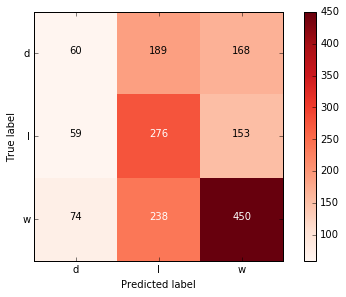

In [101]:
#Confusion Matrix for KNN
import itertools
from sklearn.metrics import confusion_matrix

 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm,title='Confusion matrix', classes=neigh.classes_, normalize = False, cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
   # plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        
        print("Goal Features: Normalized confusion matrix")
    else:
        print('Goal Features: Confusion matrix, without normalization')

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


 
  

    
 

cnf_matrix = confusion_matrix(y_test,y_pred_knn,labels = clf_forest.classes_ )

plot_confusion_matrix(cnf_matrix,neigh.classes_)
plt.figure()




**Gausian Naive Bayes**

In [102]:
from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB()
clf_gnb = clf_gnb.fit(x_train,y_train)


In [103]:
gnbtrain_score = clf_gnb.score(x_train, y_train)
gnbtest_score = clf_gnb.score(x_test, y_test)
gnbtrain_score,gnbtest_score 

(0.47029702970297027, 0.47630473905218956)